## Obective: 
To build a model that tests if we can anticipate churn based on \
customers’ responses for CSATs and Likelihood of repurchase per market (country, brand)

Load CSATs & churn \
--> CSAT_average_score; Likelihood of repurchase; probability_churn


# load libraries, set parameters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
dir_main = ('/content/drive/')
dir_mount = dir_main + 'My Drive/'
dir_ML = dir_mount + '/Colab Notebooks/Housing'
dir_data = dir_ML + '/data_customer_CSAT/'

In [3]:
drive.mount(dir_main)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
csats_name = 'CSATS_data.csv'
csats = pd.read_csv(dir_data + csats_name, sep=';')#, index = False)#,header=None)#, encoding="UTF-16LE")#, index_col = False)

churn_name = 'Churn_data.csv'
churn = pd.read_csv(dir_data + churn_name, sep=';')

# Probability purchase

## Explore list

In [5]:
csats = csats.rename(columns=csats.iloc[0])

In [6]:
new_header = csats.iloc[0] #grab the first row for the header
csats = csats[1:] #take the data less the header row
csats.columns = new_header #set the header row as the df header

In [7]:
csats.head(2)

,Start Date,"How satisfied are you with the first impression, look and feel, assembly, attention to detail and ca","In addition, for the box that you received this week, how satisfied are you with the following: - Fulfilment and Presentation","In addition, for the box that you received this week, how satisfied are you with the following: - Packaging Quality","In addition, for the box that you received this week, how satisfied are you with the following: - Ease of Recycling","How does the quality of the ingredients compare to what you would purchase for yourself? - Dry Goods (e.g. cans, bread, pasta, etc.)","How does the quality of the ingredients compare to what you would purchase for yourself? - Meat, Poultry, and Fish","How does the quality of the ingredients compare to what you would purchase for yourself? - Plant-Based Protein (e.g. tofu, tempeh, seitan, etc.)","How does the quality of the ingredients compare to what you would purchase for yourself? - Dairy (e.g. milk, yogurt, cheese, etc.)",How does the quality of the ingredients compare to what you would purchase for yourself? - Fruits and Vegetables,How likely will you purchase a next box from us?,Ingredient Quality CSAT Score,Packaging Quality CSAT Score,u,brand,country,Fulfillment Center,Ingredient Quality CSAT Score,Packaging Quality CSAT Score
1,2020-08-01 00:12:08,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Same Quality,Same Quality,NaN,NaN,Same Quality,Very Likely,180,200,1733998,ms,nl,NWG,60,100
2,2020-08-01 00:17:12,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Satisfied,Same Quality,Same Quality,Same Quality,NaN,Same Quality,Very Likely,240,180,1756827,ms,au,MEL1,60,90


## Feature engineering (CSATS_score)

In [8]:
# feature rename
csats_column_names = \
['Start_date', 'First_impression', 'Sat_Fulfilment', 'Sat_Pack_quality', 'Sat_Easy_recycling', 'Qual_Dry_goods', 'Qual_Meat', 'Qual_Plant_Protein', 'Qual_Dairy', 'Qual_Fruits', \
 'Repurchase', 'Ingredient_CSAT','Pack_CSAT', 'u', 'brand', 'country', 'Fulfill', 'Ingredient_CSAT2', 'Pack_CSAT2']

In [9]:
csats.columns = csats_column_names

In [10]:
csats.head(2)

,Start_date,First_impression,Sat_Fulfilment,Sat_Pack_quality,Sat_Easy_recycling,Qual_Dry_goods,Qual_Meat,Qual_Plant_Protein,Qual_Dairy,Qual_Fruits,Repurchase,Ingredient_CSAT,Pack_CSAT,u,brand,country,Fulfill,Ingredient_CSAT2,Pack_CSAT2
1,2020-08-01 00:12:08,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Same Quality,Same Quality,NaN,NaN,Same Quality,Very Likely,180,200,1733998,ms,nl,NWG,60,100
2,2020-08-01 00:17:12,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Satisfied,Same Quality,Same Quality,Same Quality,NaN,Same Quality,Very Likely,240,180,1756827,ms,au,MEL1,60,90


## Content engineering

### column satisfiy (col_sats)

In [11]:
# function removing unnecessary characters + change Satisfied --> (-2 ~ +2)
sat_map = {'Very Satisfied ': 2, 'Satisfied': 1, 'It was OK': 0, 'Unsatisfied': -1, 'Very Unsatisfied ': -2 }
def remove_char(df: pd, col:str):
  df[col] = df[col].str.replace(r"[^ \w\s]", '') #remove extra spaces after words
  df[col] = df[col].replace(sat_map)
  return df

In [12]:
csats_new = csats.copy()
col_sats = ['First_impression', 'Sat_Fulfilment', 'Sat_Pack_quality', 'Sat_Easy_recycling']
for col in col_sats:
  csats_new = remove_char(csats_new, col)

### column quality (col_quals)

In [13]:
# function changing quality columns
qual_map = {'Much Better': 2, 'Slightly Better': 1, 'Same Quality': 0, 'Slightly Worse': -1, 'Much Worse': -2 }
def qual_df_map(df: pd, col:str):
  df[col] = df[col].replace(qual_map)
  return df

In [14]:
csats_new2 = csats_new.copy()
col_quals = ['Qual_Dry_goods', 'Qual_Meat', 'Qual_Plant_Protein', 'Qual_Dairy', 'Qual_Fruits']
for col in col_quals:
  csats_new2 = qual_df_map(csats_new2, col)

### column Likely (col_likely)

In [15]:
# function changing likely columns
repurchase_map = {'Extremely Likely': 2, 'Very Likely': 1, 'Somewhat Likely': 0, 'Not so Likely': -1, 'Not at all Likely': -2 }
def df_map_likely(df: pd, col:str):
  df[col] = df[col].replace(repurchase_map)
  return df

In [16]:
csats_new3 = csats_new2.copy()
col_likely = ['Repurchase']
for col in col_likely:
  csats_new3 = df_map_likely(csats_new3, col)

In [17]:
csats_drop = csats_new3.drop(columns=['Start_date', 'u'])

In [18]:
csats_drop.head(2)

,First_impression,Sat_Fulfilment,Sat_Pack_quality,Sat_Easy_recycling,Qual_Dry_goods,Qual_Meat,Qual_Plant_Protein,Qual_Dairy,Qual_Fruits,Repurchase,Ingredient_CSAT,Pack_CSAT,brand,country,Fulfill,Ingredient_CSAT2,Pack_CSAT2
1,2.0,2.0,2.0,2.0,0.0,0.0,NaN,NaN,0.0,1.0,180,200,ms,nl,NWG,60,100
2,2.0,2.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,1.0,240,180,ms,au,MEL1,60,90


# CSAT score

In [19]:
col_scores = ['Ingredient_CSAT', 'Pack_CSAT', 'Ingredient_CSAT2', 'Pack_CSAT2']
for col in col_scores:
  csats_drop[col] = csats_drop[col].astype('float64')

In [20]:
CSATS_avg = csats_drop.groupby(['country', 'brand'])['Ingredient_CSAT'].agg('mean')

In [21]:
CSATS_avg.to_csv(dir_data + 'CSATS_avg.csv')

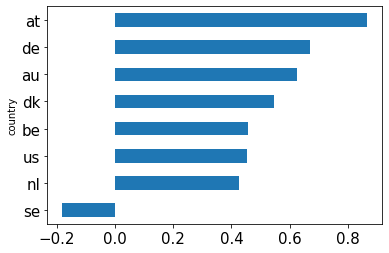

In [22]:
csats_drop.groupby('country')['Repurchase'].agg('mean').sort_values(ascending=True).plot(kind='barh', fontsize='15')

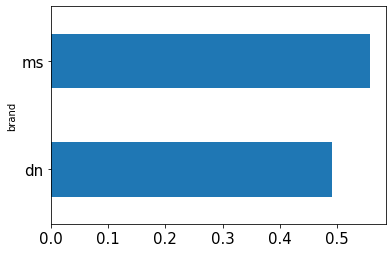

In [23]:
csats_drop.groupby('brand')['Repurchase'].agg('mean').sort_values(ascending=True).plot(kind='barh', fontsize='15')

# Probability churn rate

## Feature engineering

In [24]:
# feature rename
churn_column_names = \
['customer_id', 'brand', 'country', 'event_date', 'reason', 'location']

In [25]:
churn.columns = churn_column_names

In [26]:
churn.head(2)

,customer_id,brand,country,event_date,reason,location
0,30927,ms,de,29/09/2020,the_recipes_dont_vary_enough,NWG
1,32781,ms,de,29/09/2020,i_prefer_another_meal_kit_to_marley_spoon,NWG


In [27]:
from sklearn.preprocessing import OneHotEncoder
churn_dum = pd.get_dummies(churn, columns=["location"], prefix=["Loc"] )
churn_dum2 = pd.get_dummies(churn_dum, columns=["reason"], prefix=["Reason"] )

In [28]:
churn_dum2.head(2)

,customer_id,brand,country,event_date,Loc_CA1,Loc_EXT-NL,Loc_MEL1,Loc_NWG,Loc_NYC1,Loc_SYD1,Loc_TEX1,Reason_customer_service_did_not_reply_in_time,Reason_delivery_instructions_were_not_followed,Reason_email_no_reason,Reason_i_am_a_customer_of_multiple_meal_kit_services,Reason_i_am_cooking_but_no_one_is_eating_my_kids_are_picky,Reason_i_am_moving_out_of_your_delivery_area,Reason_i_am_not_happy_with_the_attitude_of_the_customer_service_employee,Reason_i_didnt_receive_my_box,Reason_i_dont_want_a_subscription_and_would_prefer_single_orders,Reason_i_need_more_meal_planning_flexibility,Reason_i_prefer_another_meal_kit_to_marley_spoon,Reason_i_travel_often,Reason_i_want_to_try_a_different_meal_kit,Reason_i_want_to_try_the_product_before_subscribing,Reason_i_was_missing_ingredients,Reason_i_was_reactivated_without_my_consent,Reason_i_will_not_able_to_use_the_service_anymore,Reason_ingredients_were_damaged,Reason_it_does_not_fit_my_budget,Reason_its_not_good_value_for_money,Reason_marketing_account,Reason_my_delivery_was_damaged,Reason_my_delivery_was_delayed,Reason_my_family_situation_is_changing,Reason_my_order_was_not_cancelled,Reason_my_problem_was_not_resolved,Reason_payment_failure,Reason_test_account,Reason_the_ingredients_do_not_fit_my_dietary_requirements,Reason_the_portion_sizes_are_too_small,Reason_the_quality_of_ingredients_was_disappointing,Reason_the_recipes_are_boring,Reason_the_recipes_are_too_exotic,Reason_the_recipes_dont_vary_enough,Reason_the_recipes_take_too_long_to_cook,Reason_there_is_too_much_packaging,Reason_website_app_was_hard_to_use
0,30927,ms,de,29/09/2020,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,32781,ms,de,29/09/2020,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


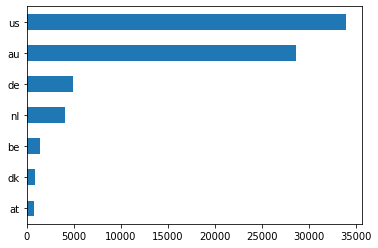

In [29]:
churn_dum2['country'].value_counts()[:7].sort_values(ascending=True).plot(kind='barh')

In [30]:
churn_dum2[churn_dum2['country']=='de'].drop(['customer_id'], axis=1).mean().sort_values(ascending=False)[:10]

Loc_NWG                                                             0.889024
Reason_i_dont_want_a_subscription_and_would_prefer_single_orders    0.152161
Loc_EXT-NL                                                          0.110976
Reason_its_not_good_value_for_money                                 0.099209
Reason_i_travel_often                                               0.081761
Reason_it_does_not_fit_my_budget                                    0.076892
Reason_i_want_to_try_the_product_before_subscribing                 0.069385
Reason_i_want_to_try_a_different_meal_kit                           0.057821
Reason_i_need_more_meal_planning_flexibility                        0.043822
Reason_my_family_situation_is_changing                              0.042199
dtype: float64

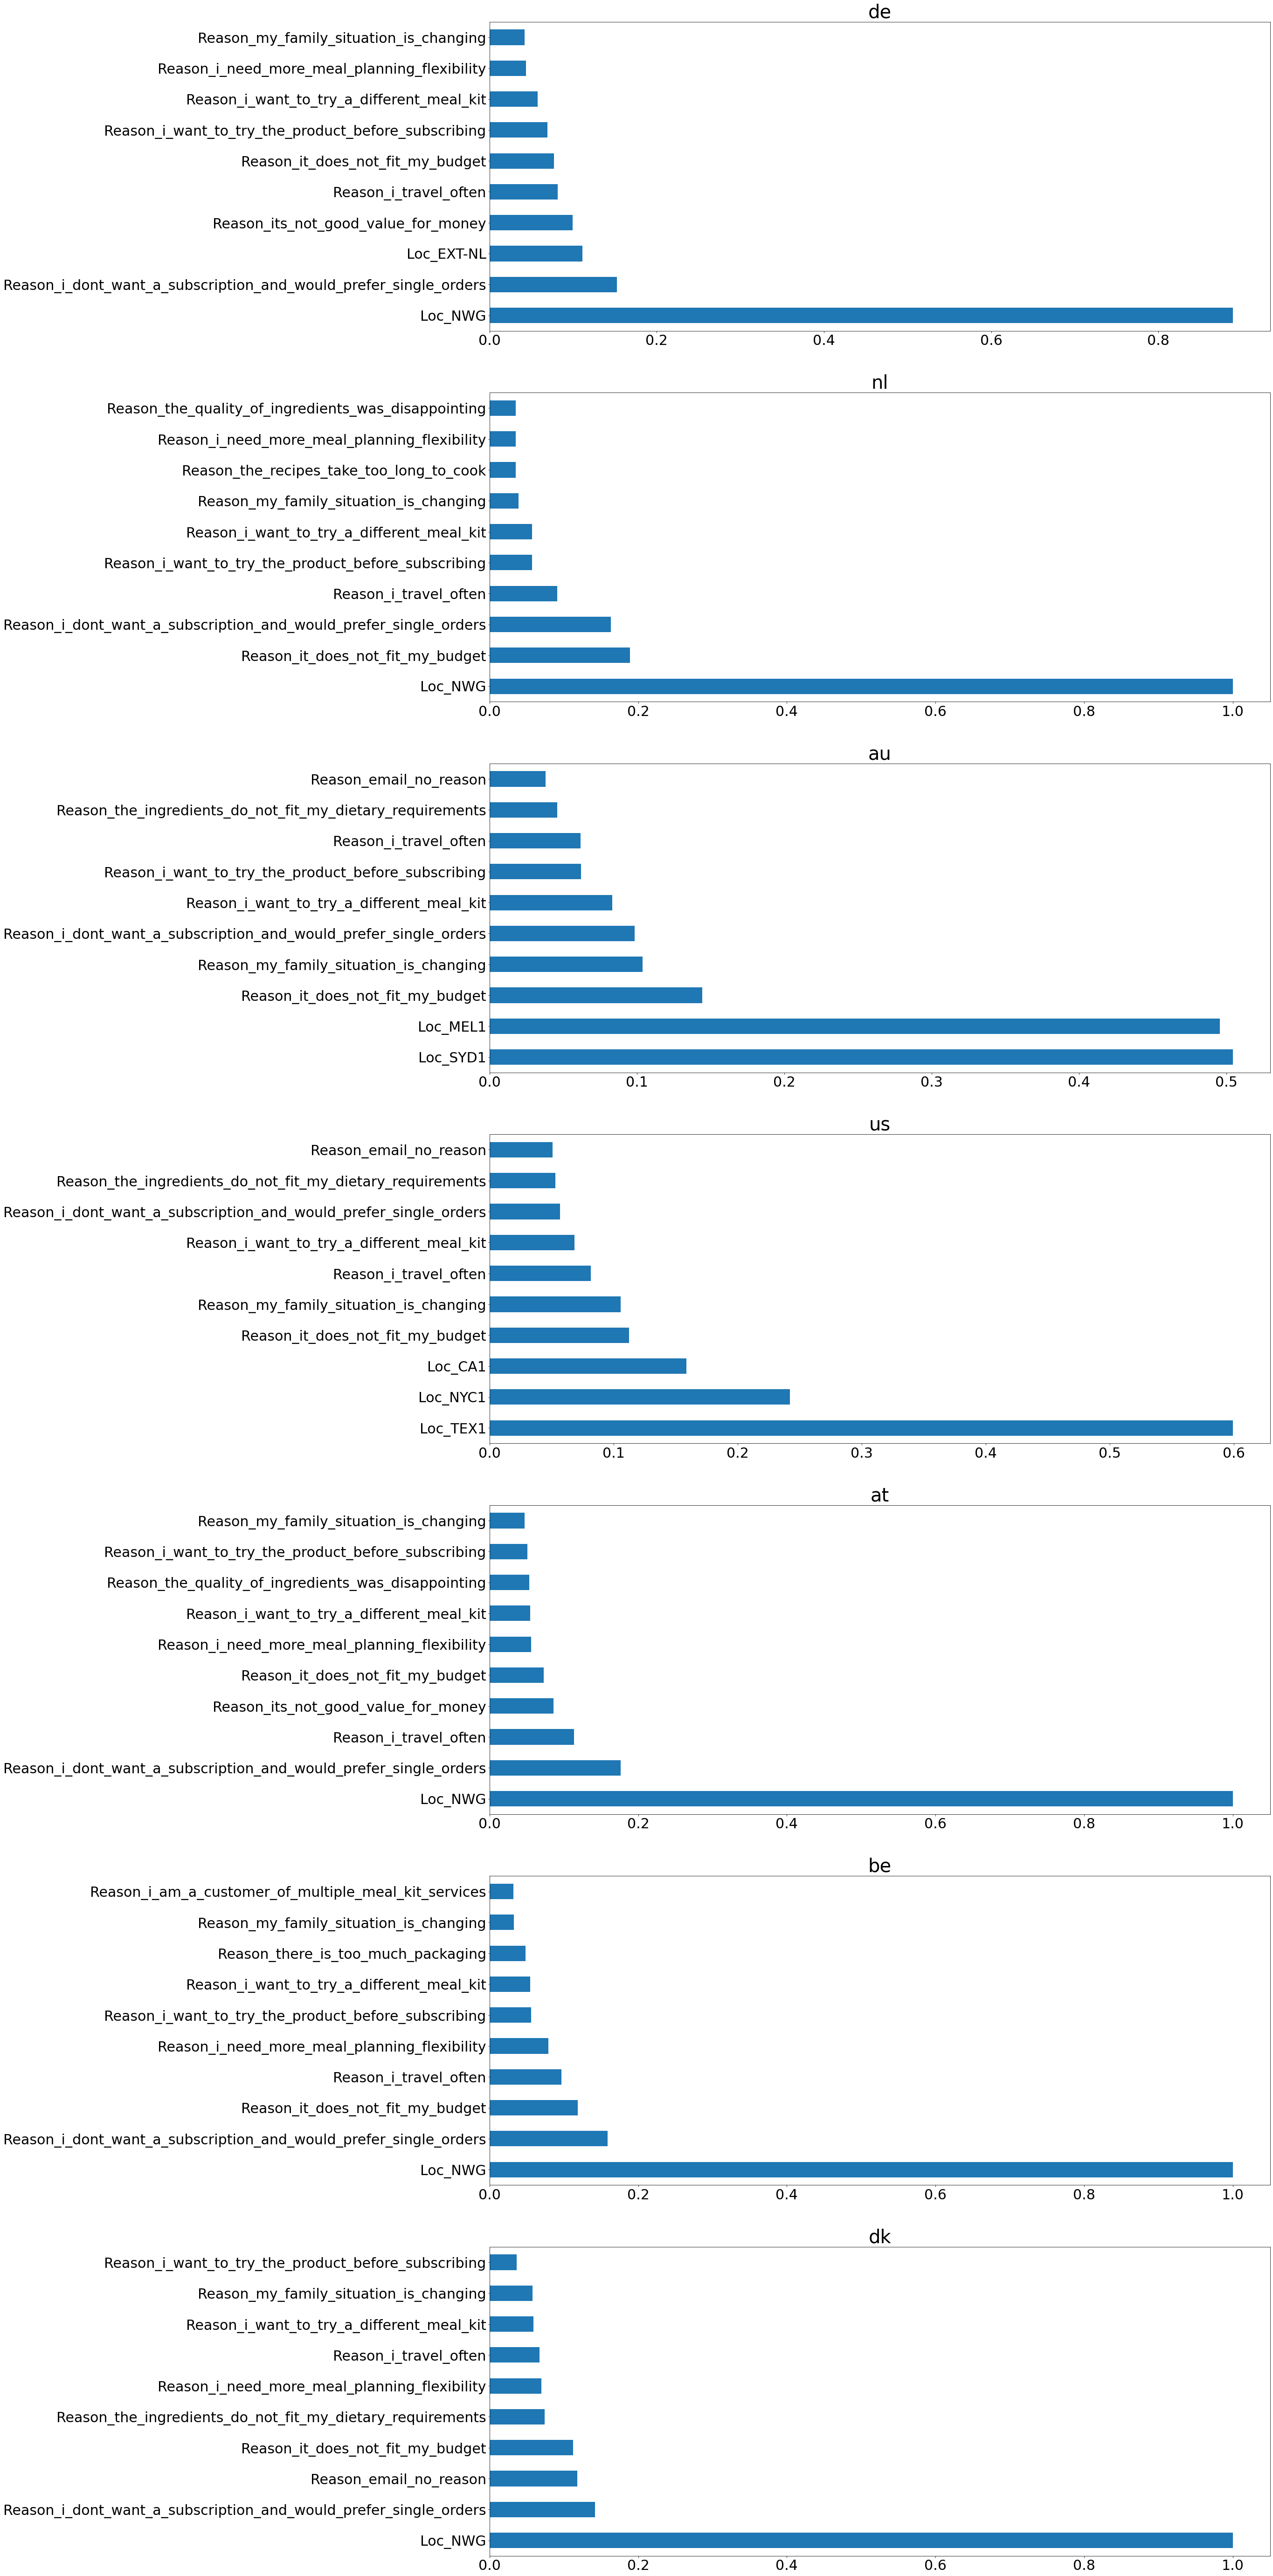

In [31]:
country_list = ['de', 'nl', 'au', 'us', 'at', 'be', 'dk']
from matplotlib.pyplot import figure
fig, axes = plt.subplots(nrows=7, ncols=1)
fig.set_size_inches(30,100)
for c in range(7):
  col = int(c/1); row = c%1
  country = country_list[c]
  churn_dum2[churn_dum2['country']==country].drop(['customer_id'], axis=1).mean().sort_values(ascending=False)[:10].plot(kind='barh', ax=axes[c], fontsize='30')
  axes[c].set_title(country, fontsize='40')
plt.show()

## Content engineering

In [32]:
churn_feat = ['brand', 'country', 'event_date','reason', 'location']
churn[churn_feat]

,brand,country,event_date,reason,location
0,ms,de,29/09/2020,the_recipes_dont_vary_enough,NWG
1,ms,de,29/09/2020,i_prefer_another_meal_kit_to_marley_spoon,NWG
2,ms,de,29/09/2020,i_travel_often,NWG
3,ms,nl,29/09/2020,i_prefer_another_meal_kit_to_marley_spoon,NWG
4,ms,nl,29/09/2020,i_was_missing_ingredients,NWG
...,...,...,...,...,...
75189,ms,nl,01/09/2020,i_am_a_customer_of_multiple_meal_kit_services,NWG
75190,dn,us,01/09/2020,email_no_reason,TEX1
75191,dn,us,01/09/2020,delivery_instructions_were_not_followed,TEX1
75192,dn,us,01/09/2020,the_portion_sizes_are_too_small,TEX1


## Predict churn rate

# Simple EDA (each brand)

In [33]:
! pip install plotly==4.12.0

In [34]:
import plotly.express as px

In [35]:
import matplotlib.pyplot as plt

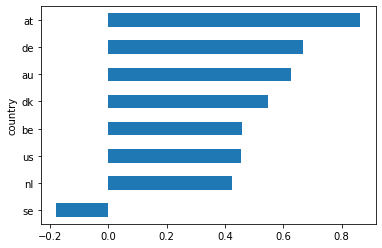

In [36]:
avg_purchase = csats_drop.groupby('country')['Repurchase'].agg('mean').sort_values(ascending=False)
avg_purchase.sort_values(ascending=True).plot(kind='barh')
plt.show()

# Likelihood of repurchase
Calculate by correlation with repurchase

In [37]:
csats_drop.groupby(['brand']).mean()

,First_impression,Sat_Fulfilment,Sat_Pack_quality,Sat_Easy_recycling,Qual_Dry_goods,Qual_Meat,Qual_Plant_Protein,Qual_Dairy,Qual_Fruits,Repurchase,Ingredient_CSAT,Pack_CSAT,Ingredient_CSAT2,Pack_CSAT2
brand,,,,,,,,,,,,,,
dn,0.449912,0.473615,0.600771,0.794952,0.215611,0.229428,0.226186,0.226418,-0.024257,0.490583,266.423257,146.837443,63.248167,75.847176
ms,0.601640,0.660529,0.799496,0.828312,0.244122,0.204402,0.249676,0.210284,-0.146523,0.556345,260.796918,151.200000,62.404598,77.911913


In [38]:
cat_var = csats_drop.columns[csats_drop.dtypes == 'object'].to_list()


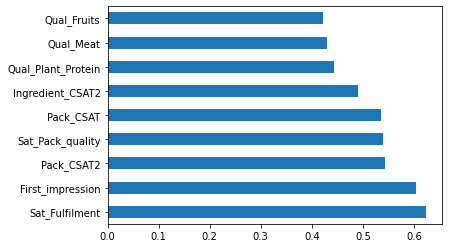

In [58]:
csats_drop.corr()['Repurchase'].sort_values(ascending=False)[1:10].plot(kind='barh')

# Experiment

In [40]:
from statsmodels.stats.anova import AnovaRM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [41]:
d_melt = pd.melt(csats_drop, id_vars='country', value_vars=['brand'])
d_melt.columns = ['country', 'brand', 'Repurchase']


In [42]:
d_melt=csats_drop[['country', 'brand', 'Repurchase']]

In [43]:
d_melt

,country,brand,Repurchase
1,nl,ms,1.0
2,au,ms,1.0
3,be,ms,2.0
4,au,ms,NaN
5,au,ms,2.0
...,...,...,...
18433,us,dn,2.0
18434,be,ms,1.0
18435,us,dn,1.0
18436,us,dn,0.0


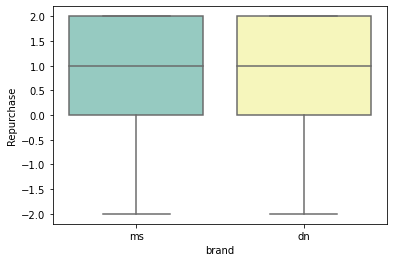

In [44]:
import seaborn as sns
sns.boxplot(x="brand", y="Repurchase", data=d_melt, palette="Set3") 


# Machine learning

## X, Y

In [45]:
Y = csats_drop['Repurchase']
X = csats_drop.drop(['Repurchase'], axis=1)

## Train, Test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Catboost

In [47]:
import lightgbm as lgb

lgbm_X_train = X_train.copy()
lgbm_X_train[cat_var] = lgbm_X_train[cat_var].astype('category')

lgbm_X_test = X_test.copy()
lgbm_X_test[cat_var] = lgbm_X_test[cat_var].astype('category')

In [48]:
# before corona update
lgbm_X_train[cat_var] = lgbm_X_train[cat_var].astype('category')
lgbm_X_test[cat_var] = lgbm_X_test[cat_var].astype('category')

In [49]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
score_func = make_scorer(mean_absolute_error, greater_is_better=False)

In [50]:
param_dict = {
 'task': 'train', 
 'boosting_type': 'gbdt', 
 'objective': 'regression', 
 'metric': 'rmsle', 
 'tree_learner': 'feature',
 'max_depth':5,#8,10
 'min_child_samples':2 ,#4,2
 'num_leaves': 10,#20,#20,
 'n_estimators': 900
}

In [51]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()

In [52]:
model.set_params(**param_dict)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              metric='rmsle', min_child_samples=2, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=900, n_jobs=-1, num_leaves=10,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              tree_learner='feature')

In [53]:
model = model.fit(lgbm_X_train, y_train)

In [54]:
feat_imp = pd.DataFrame({'importance': model.feature_importances_})    
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:30]

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)

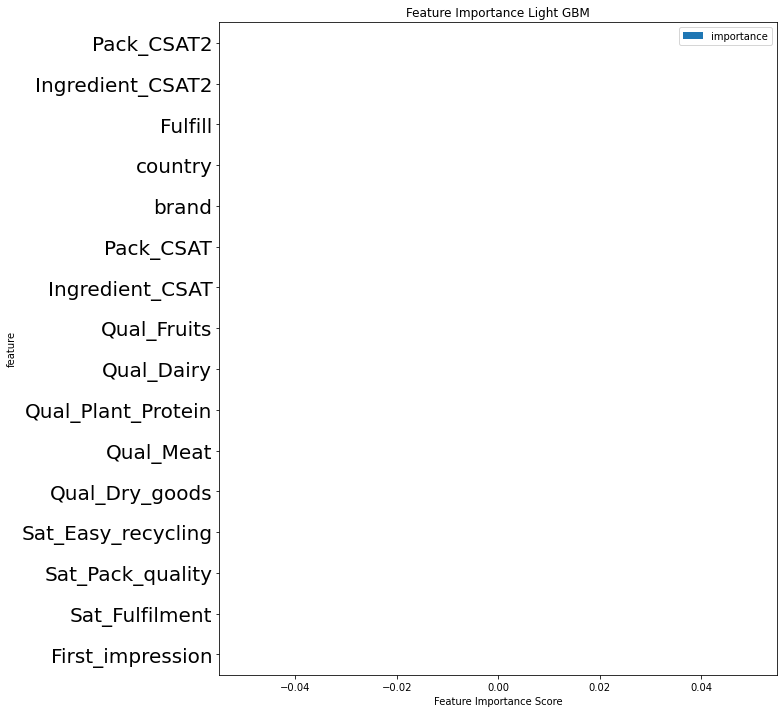

In [55]:
fig = feat_imp.plot.barh(title='Feature Importance Light GBM', figsize = (10,12))
fig.set_yticklabels(fig.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize = 20)
plt.xlabel('Feature Importance Score')
plt.show()